In [33]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from matplotlib.pylab import rcParams
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [2]:
with open("pickled_table.pkl", "rb") as file:
    data = pickle.load(file)

In [3]:
class Data_balancing:
    def __init__(self, data) -> None:
        self.data = data
        self.ones = self.data[self.data[self.data.columns[-1]] == 1]
        self.zeros = self.data[self.data[self.data.columns[-1]] == 0]    
    
    def counts(self):
        counts = self.data.loc[:,self.data.columns[-1]].value_counts()
        return f"Count of zeros - {counts[0]},\ncount of ones - {counts[1]}."

    def balancing(self, counts):
        return self.zeros.sample(counts)

    def concat_balance(self):
        return pd.concat([self.ones, self.balancing(self.ones.shape[0])])

In [4]:
b_data = Data_balancing(data).concat_balance().reset_index().drop(["index"], axis=1)

In [5]:
class Transformation:
    def __init__(self, data) -> None:
        self.standard = StandardScaler().fit(data)
        self.scaling = MinMaxScaler().fit(data)
    
    def standarization(self, d):
        return self.standard.transform(d)

    def scal(self, d):
        return self.scaling.transform(d)

In [6]:
x = b_data.drop(b_data.columns[-1], axis=1)
y = b_data[b_data.columns[-1]]

In [7]:
x_standarized = Transformation(x).standarization(x)
x_scaling = Transformation(x).scal(x)

In [8]:
class Split:
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
    
    def splitting(self):
        return train_test_split(self.x, self.y, test_size=0.1, random_state=42) 

In [9]:
train_x, test_x, train_y, test_y = Split(x, y).splitting()
st_train_x, st_test_x, st_train_y, st_test_y = Split(x_standarized, y).splitting()
sc_train_x, sc_test_x, sc_train_y, sc_test_y = Split(x_scaling, y).splitting()

In [10]:
class Basic_model_check:
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        self.model = xgb.XGBClassifier()

    def training(self):
        return self.model.fit(self.x, self.y)

    def score(self, test_x, test_y):
        return self.training().score(test_x, test_y)

    def report(self, x_test, y_test):
        pred = self.training().predict(x_test)
        return classification_report(y_test, pred), confusion_matrix(y_test, pred)

In [11]:
basic = Basic_model_check(train_x, train_y)
standard = Basic_model_check(st_train_x, st_train_y)
scaled = Basic_model_check(sc_train_x, sc_train_y)

In [12]:
print(basic.report(x_test=test_x, y_test=test_y)[1])
print(standard.report(x_test=st_test_x, y_test=st_test_y)[1])
print(scaled.report(x_test=sc_test_x, y_test=sc_test_y)[1])
#no differances between prepared data, not standarized data will be chosed to further tunning

[[ 6  4]
 [ 0 12]]
[[ 6  4]
 [ 0 12]]
[[ 6  4]
 [ 0 12]]


In [17]:
params = {
    'max_depth': [5,6,7,8,9,10],
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.1, 0.5, 1],
    'n_estimators': [100, 200, 300, 400, 500],
    'reg_alpha': [20, 30, 40, 50, 60],
    'reg_lambda': [1,5,10]
}

In [22]:
model = xgb.XGBClassifier(colsample_bytree = 0.1, learning_rate = 0.1, max_depth = 5, n_estimators = 100, reg_alpha = 20, reg_lambda = 1).fit(train_x, train_y)

In [18]:
grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    verbose=1)

In [19]:
grid.fit(test_x, test_y)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits


GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_to_...
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1, ...),
             param_grid={'colsample_bytree': [0.1, 0.5, 1],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'reg_alpha': [20, 30, 40, 50, 60],
                         'reg_lambda': [1, 5, 10]},
             verbose=1)

In [20]:
print("Best parameters:", grid.best_params_)

Best parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 20, 'reg_lambda': 1}


In [23]:
model.score(test_x, test_y)

0.8181818181818182

In [25]:
pred = model.predict(test_x)

In [27]:
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.79      0.92      0.85        12

    accuracy                           0.82        22
   macro avg       0.83      0.81      0.81        22
weighted avg       0.83      0.82      0.82        22



In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [30]:
roc_auc_score(test_y, pred)

0.8083333333333332

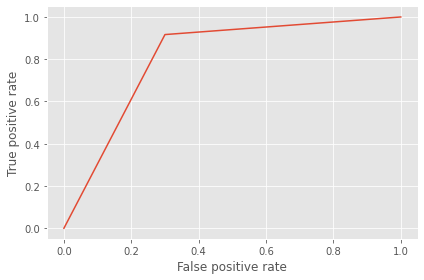

In [36]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, pred)

plt.style.use("ggplot")
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.tight_layout()
plt.show()

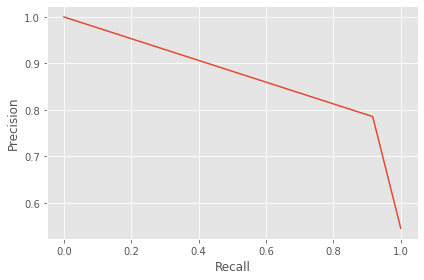

In [39]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(test_y, pred)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

In [41]:
with open("model.pkl", "wb") as file:
    pickle.dump(model, file)